## Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов.

Необходимо построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from scipy.optimize import minimize
import statsmodels.api as sm

from itertools import product

from tqdm import tqdm_notebook


import warnings
warnings.filterwarnings("ignore")

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 1. Data preparing

In [2]:
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=['date_time'])
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Нам понадобятся только 4 столбца датасета - `traffic_volume` (целевая переменная), `date_time`, `holiday` (является ли день праздником) и `temp` (температура воздуха). Остальные столбцы удаляем.

In [3]:
data.drop(columns=['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'], inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         48204 non-null  object        
 1   temp            48204 non-null  float64       
 2   date_time       48204 non-null  datetime64[ns]
 3   traffic_volume  48204 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
data.duplicated().sum()

7551

In [6]:
data.date_time.duplicated().sum()

7629

In [7]:
data.drop(index=data[data.date_time.duplicated()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
data.holiday.value_counts()

None                         40522
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

Так как всех праздничных дней всего 0.13% от общего кол-ва наблюдений, приводим все их значения к 1, а значения непраздничынх дней к 0.

In [9]:
data.holiday.replace(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'New Years Day', 'Washingtons Birthday', 'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day', 'Martin Luther King Jr Day'],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], inplace=True)

Проверим временную последовательность на монотонность.

In [10]:
data.date_time.is_monotonic

True

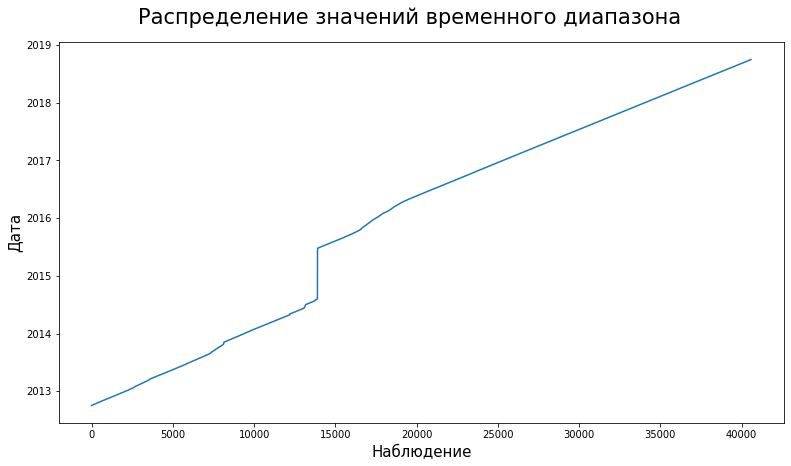

In [11]:
def date_time_plot(data):

    data.plot(figsize=(13, 7))
    plt.suptitle('Распределение значений временного диапазона', fontsize=21, y=0.95)
    plt.xlabel('Наблюдение', fontsize=15)
    plt.ylabel('Дата', fontsize=15)
    plt.show()

date_time_plot(data.date_time)

По графику видно, что нарушена равномерность временных интервалов - добавим недостающие временные значения.

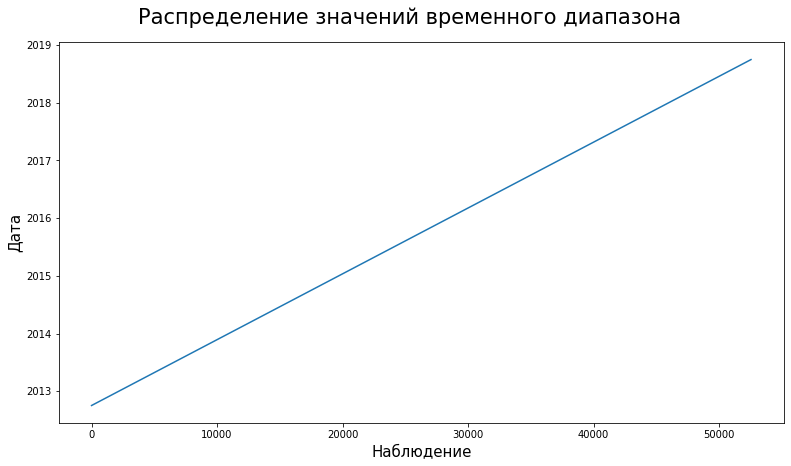

In [12]:
full_datetime = pd.DataFrame({'date_time': pd.date_range(start=data.date_time.min(), end=data.date_time.max(), freq='H')})
data_new = pd.merge(data, full_datetime, how='outer', on='date_time')
data_new.sort_values(by='date_time', inplace=True)
data_new.reset_index(drop=True, inplace=True)
date_time_plot(data_new.date_time)

Заполним образовавшиеся пропуски в признаках `temp` и `traffic_volume` при помощи линейной интерполяции. В признаке `holiday` пропуски заполним значением 0, т.к. их в датасете порядка 99.9%.

In [13]:
data_new.holiday.fillna(0, inplace=True)
data_new['temp'].interpolate(method='linear', inplace=True)
data_new['traffic_volume'].interpolate(method='linear', inplace=True)
data_new.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

## 2. Modeling

Необходимо построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю, т.е. на 168 точек вперёд.

Для удобства переведем столбец с датами в индекс.

In [14]:
data_new.index = data_new.date_time
data_new.drop(columns='date_time', inplace=True)

Посмотрим на релевантность исторических данных для прогнозов текущих значений.

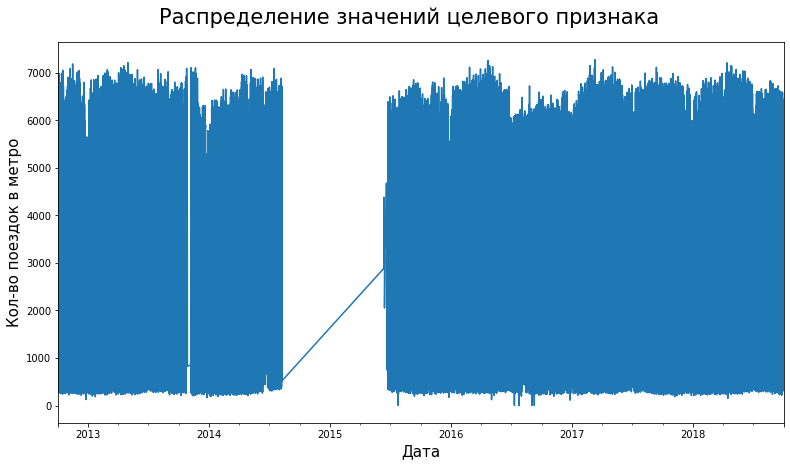

In [15]:
data_new['traffic_volume'].plot(figsize=(13, 7))
plt.suptitle('Распределение значений целевого признака', fontsize=21, y=0.95)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Кол-во поездок в метро', fontsize=15)

plt.show()

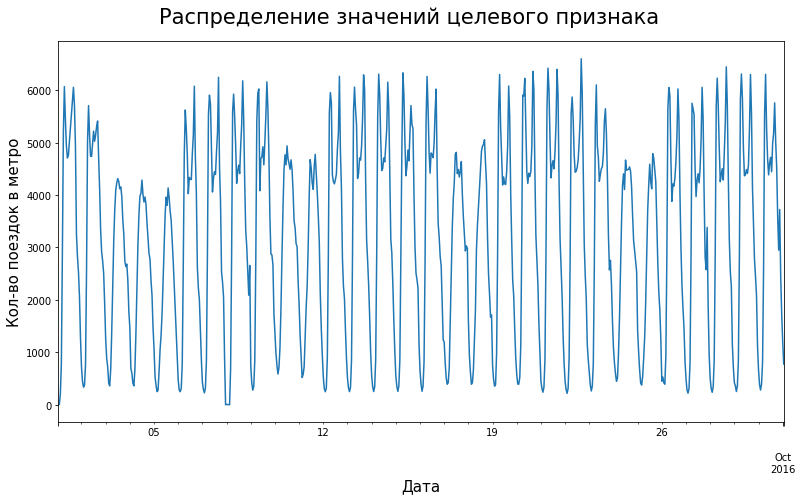

In [16]:
data_new.loc['2016-09-01 01:00:00':'2016-10-01 01:00:00', 'traffic_volume'].plot(figsize=(13, 7))
plt.suptitle('Распределение значений целевого признака', fontsize=21, y=0.95)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Кол-во поездок в метро', fontsize=15)

plt.show()

Посмотрим на тренд, сезонную составляющую и осаток во временном ряде.

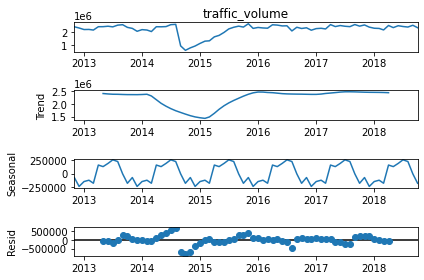

In [17]:
decomposition = sm.tsa.seasonal_decompose(data_new['traffic_volume'].resample('M').sum(), model='additive')
decomposition.plot()
rcParams['figure.figsize'] = 13, 7
plt.show()

In [18]:
# data_new.groupby(pd.Grouper(freq='M')).sum()['traffic_volume'].plot(figsize=(13, 7))
# plt.suptitle('Распределение значений целевого признака в разрезе месяца', fontsize=21, y=0.95)
# plt.xlabel('Дата', fontsize=15)
# plt.ylabel('Кол-во поездок в метро', fontsize=15)
# plt.show()

Присутствует четко выраженная годовая сезонность. Видны суточные циклы, также есть недельные циклы (в рабочие дни загрузка метро больше). Тренда нет `(в среднем порядка 2.5 млн поездок в месяц)`, есть несколько аномалий, которые можно определить визуально - в 4 квартале 2013 года и в промежутке с 3 квартала 2014 года по 3 квартал 2015 года. Данные аномалии появились скорее всего в процессе заполнения пропусков интерполяцией и будут негативно влиять на качество модели. Удалим данные с начала наблюдений и до 3 квартала 2015 года.

In [19]:
data_new = data_new[data_new.index > '2015-07-01 00:00:00']

Создаем классы и функции для генерирации дополнительных признаков из даты, применения тригонометрических функций к извлекаемым циклическим категориальным значениям (дни недели, месяцы и часы) для приведения их к сопоставимой значимости (берем sin и cos, чтобы они уравновешивали друг друга и не было перекоса в данных), добавления лаговых признаков и средних значений по ним из сгруппированных данных.

In [20]:
def create_time_features(data):

    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['hour'] = data.index.hour

    data['day_of_week_cos'], data['day_of_week_sin'] = np.cos(2 * np.pi * data['day_of_week'] / 6), np.sin(2 * np.pi * data['day_of_week'] / 6)
    data['month_cos'], data['month_sin'] = np.cos(2 * np.pi * data['month'] / 12), np.sin(2 * np.pi * data['month'] / 12)
    data['hour_cos'], data['hour_sin'] = np.cos(2 * np.pi * data['hour'] / 23), np.sin(2 * np.pi * data['hour'] / 23)

    data['weekend'] = data.index.dayofweek.isin([5,6]).astype('int')

    return data


class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None
    
    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]
    
    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val

class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags


# функция формирования признаков для обучающей выборки
def prepare_train_data(series):
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    data = pd.concat([df_series, df_lags], axis=1)
    
    data = create_time_features(data)

    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)
    
    data.loc[:, :] = scaler.fit_transform(data)
    
    feat_cols = data.columns.tolist()
    feat_cols.remove("x")
    
    Y = data["x"]
    X = data[feat_cols]
    
    forecast_start_X = data.loc[data.index[-1],["x"] + lag_encoder.lag_columns[:-1]]
    forecast_start_X.index = lag_encoder.lag_columns
    
    return X, Y, feat_cols, forecast_start_X

# функции формирования признаков для тестовой выборки
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    forecast_df = pd.DataFrame(columns=["x"]+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)
    
    forecast_df.loc[:, :] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df


# функция для выполнения прогноза
def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("x")
    
    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "x"] = forecast
    df_pred.loc[:, :] = scaler.inverse_transform(df_pred)
    return df_pred


# построение графика прогноза
def plotRecursivePrediction(y_test, y_forecast):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

Переименуем название целевого признака на `x` и отложим последние 2 недели датасета для тестирования моделей.

In [21]:
data_new.rename(columns={'traffic_volume':'x'}, inplace=True)

split_date = data_new.index.max() - pd.Timedelta(weeks=2)

data_train = data_new[data_new.index <= split_date]
data_test = data_new[data_new.index > split_date]

data_train.shape, data_test.shape

((28175, 3), (336, 3))

Инициализируем классы для последующего извлечения признаков.

In [22]:
mean_encoder = MeanEncoder(y_col="x", cat_feat=["day_of_week", "month", "hour", "weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=24) # возьмем суточный цикл (также можно взять и недельный с end_lag=168, но считаться будет значительно дольше)

In [23]:
X_train, Y_train, feat_cols, forecast_start_X = prepare_train_data(data_train.x)
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,month,hour,day_of_week_cos,day_of_week_sin,month_cos,month_sin,hour_cos,hour_sin,weekend,mean_code
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-02 01:00:00,-1.044677,-0.251852,-0.488428,-0.268156,-0.086637,0.170851,0.657769,1.353684,1.476469,1.177132,...,0.11715,-1.516968,-1.538588,0.002256,-1.180198,-0.629776,1.278720,0.389750,-0.633604,-1.510962
2015-07-02 02:00:00,-1.401077,-1.044708,-0.251846,-0.488422,-0.268152,-0.086636,0.170842,0.657727,1.353597,1.476402,...,0.11715,-1.372501,-1.538588,0.002256,-1.180198,-0.629776,1.128128,0.750593,-0.633604,-1.569714
2015-07-02 03:00:00,-1.499482,-1.401111,-1.044701,-0.251840,-0.488417,-0.268151,-0.086643,0.170812,0.657665,1.353533,...,0.11715,-1.228033,-1.538588,0.002256,-1.180198,-0.629776,0.889582,1.055769,-0.633604,-1.553069
2015-07-02 04:00:00,-1.508149,-1.499517,-1.401104,-1.044695,-0.251836,-0.488416,-0.268158,-0.086667,0.170767,0.657617,...,0.11715,-1.083566,-1.538588,0.002256,-1.180198,-0.629776,0.580774,1.282643,-0.633604,-1.281555
2015-07-02 05:00:00,-1.281257,-1.508185,-1.499509,-1.401097,-1.044690,-0.251835,-0.488422,-0.268177,-0.086702,0.170731,...,0.11715,-0.939098,-1.538588,0.002256,-1.180198,-0.629776,0.224607,1.414389,-0.633604,-0.233519


Строим baseline-прогноз, основанный на средних значениях `x` по часам и дням недели. Месяцы в расчет не берем, т.к. тестовая выборка продолжительностью всего 2 недели.

In [24]:
baseline_df_train = create_time_features(data_train)
baseline_df_test = create_time_features(data_test)
baseline_predict = baseline_df_train.groupby(['day_of_week', 'hour'])['x'].mean()

Проверяем начало дат прогноза и факта на соответсвие.

In [25]:
list(baseline_predict.index[0]) == baseline_df_test.loc[baseline_df_test.iloc[0, :].name, ['day_of_week', 'hour']].values.tolist()

True

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Средняя абсолютная процентная ошибка baseline-прогноза составляет {:.2f} %'.format(mean_absolute_percentage_error(data_test['x'].values, baseline_predict.append(baseline_predict).values)))

Средняя абсолютная процентная ошибка baseline-прогноза составляет 9.30 %


Строим модели `SARIMAX, linear regression` и `XGBoost` для прогнозирования загрузки метро.

Сначала проверим стационарность временного ряда.

In [27]:
test = sm.tsa.stattools.adfuller(Y_train)

print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -21.99627663285952
p-value:  0.0
Critical values:  {'1%': -3.430582736564667, '5%': -2.861642863015191, '10%': -2.566824750888413}
единичных корней нет, ряд стационарен


Ряд стационарен, поэтому с ним не нужно проводить дополнительных действий.

Строим модель `SARIMAX`.

In [28]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)

In [29]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    :param parameters_list:  list with (p, q, P, Q) tuples
    :type parameters_list:    list
    :param d:                integration order in ARIMA model
    :type d:                  int
    :param D:                seasonal integration order
    :type D:                  int
    :param s:                length of season
    :type s:                  int
    """
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

Преобразуем целевые показатели в формат Dataframe.

In [30]:
Y_train_df = pd.DataFrame(Y_train.values, index=Y_train.index, columns=['x'])

In [31]:
# оптимайзер не используем, т.к. он выполняется нереально долго

# ps = range(2, 4)
# d = 1
# qs = range(2, 4)
# Ps = range(0, 3)
# D = 1
# Qs = range(0, 3)
# s = 168

# # creating list with all the possible combinations of parameters
# parameters_list = list(product(ps, qs, Ps, Qs))

# result_table = optimizeSARIMA(Y_train_df.traffic_volume, parameters_list, d, D, s)

In [32]:
# p, d, q = 3, 1, 3
# P, D, Q = 1, 1, 2

# Y_train_df.traffic_volume = Y_train_df.traffic_volume.astype('int64')

p, d, q = 1, 1, 1
P, D, Q = 0, 1, 0
s = 168

# model_sarimax = sm.tsa.statespace.SARIMAX(Y_train_df.traffic_volume,
#                                   order=(p, d, q),
#                                   seasonal_order=(P, D, Q, s)).fit(disp=-1)

При недельной сезонности (s = 168) обучение модели `Sarimax` на выборке с 28151 наблюдением приводит к загрузке более 50 Гб оперативной памяти и ошибке "MemoryError: Unable to allocate ... GiB for an array with shape (...) and data type float64". Уменьшаем размер обучающей выборки для модели `Sarimax` до 10000 наблюдений.

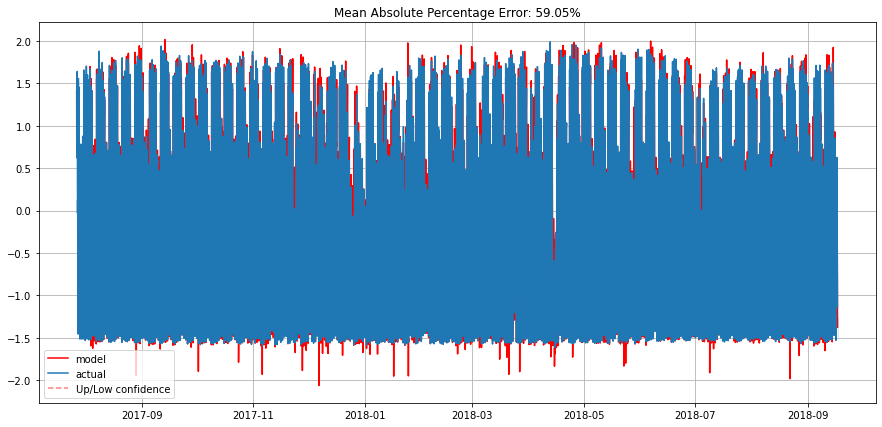

In [33]:
model_sarimax = sm.tsa.statespace.SARIMAX(Y_train_df.x[18151:],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

plotSARIMA(Y_train_df[18151:], model_sarimax, n_steps=1, s=s, d=d, plot_intervals=True, alpha=0.5)

In [34]:
Y_pred_sarimax = model_sarimax.get_forecast(steps=336)

print('Средняя абсолютная процентная ошибка модели SARIMAX на тестовой выборке составляет {:.2f} %'.format(mean_absolute_percentage_error(data_test.x, Y_pred_sarimax.predicted_mean)))

Средняя абсолютная процентная ошибка модели SARIMAX на тестовой выборке составляет 100.07 %


У модели `SARIMAX` качество гораздо хуже, чем у baseline-прогноза. Обучим модель `linear regression`.

In [35]:
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

LinearRegression()

Проверяем качество модели на тестовой выборке.

In [36]:
df_forecast = build_forecast_df(Y_train_df, feat_cols, forecast_start_X, forecast_horizon=len(data_test))
Y_pred_lr = recursive_predict(model_lr, df_forecast)

print('Средняя абсолютная процентная ошибка модели linear regression на тестовой выборке составляет {:.2f} %'.format(mean_absolute_percentage_error(data_test.x, Y_pred_lr.x)))

Средняя абсолютная процентная ошибка модели linear regression на тестовой выборке составляет 14.74 %


У модели `linear regression` качество хуже, чем у `baseline-прогноза`, но лучше, чем у модели `SARIMAX`.

Строим модель `XGBoost`.

In [37]:
xgb_param = {'eta': [0.01, 0.1],
            'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'subsample': [0.5, 0.7],
            'min_child_weight': [2, 5],
            'colsample_bytree': [0.5, 0.7]
            }

xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', seed=800)

tscv = TimeSeriesSplit(n_splits=4)

xgb_model_grid = GridSearchCV(estimator=xgb_model, 
                            param_grid=xgb_param,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            cv=tscv,
                            verbose=1,
                            return_train_score=True)

xgb_model_grid.fit(X_train, Y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_...
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=800, subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7], 'eta': [0.01, 0.1],
                         'max_depth': [5, 10], 'min_child_weight': [2, 5],
                         'n_estimators': [200, 500], 'subsample': [0.5, 0.7]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=5)

In [38]:
xgb_best_model = xgb_model_grid.best_estimator_
Y_pred_best_xgb = recursive_predict(xgb_best_model, df_forecast)

print('Средняя абсолютная процентная ошибка лучшей модели XGBoost на тестовой выборке составляет {:.2f} %'.format(mean_absolute_percentage_error(data_test.x, Y_pred_best_xgb.x)))

Средняя абсолютная процентная ошибка лучшей модели XGBoost на тестовой выборке составляет 8.98 %


Лучшей по качеству на тестовой выборке получилась модель XGBoost со значением MAPE 8.98 %.

Используем данную выборку для построения прогноза с доверительными интервалами на следующую неделю.

In [39]:
# определение ошибок вычислений
def get_train_forecast_errors(model, X_train, y_train):
    forecast = model.predict(X_train)
    errors = y_train - forecast
    return errors


# выполнение прогноза с шумом
def recursive_predict_with_noise(model, df_forecast, noise_std=None):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("x")
    
    for i in range(horizon):
        timestamp = t[i]
        features = df_pred.loc[[timestamp], feat_cols]
        next_x = model.predict(features)[0]
        if noise_std is not None:
            next_x = next_x + np.random.normal(0, noise_std)
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "x"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred


# выполнение прогноза с шумом на бутстрэп-выборках
def sample_bootstrap_forecasts(model, df_forecast, n_samples=100, noise_std=None):    
    df_conf_int = pd.DataFrame(index=df_forecast.index)
    
    for s in tqdm_notebook(range(n_samples)):
        df_forecasted = recursive_predict_with_noise(model, df_forecast, noise_std=noise_std)
        df_conf_int["forcast_{}".format(s)] = df_forecasted.x.values
    
    return df_conf_int


# построение графика с 95% доверительным интервалом
def plotRecursivePredictionConfInterval(y_test, y_forecast, error_std):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    
    scale = 1.96
    lower = y_forecast - scale * error_std
    upper = y_forecast + scale * error_std

    plt.plot(lower.values, "r--", label="upper bond / lower bond", alpha=0.5)
    plt.plot(upper.values, "r--", alpha=0.5)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

  0%|          | 0/30 [00:00<?, ?it/s]

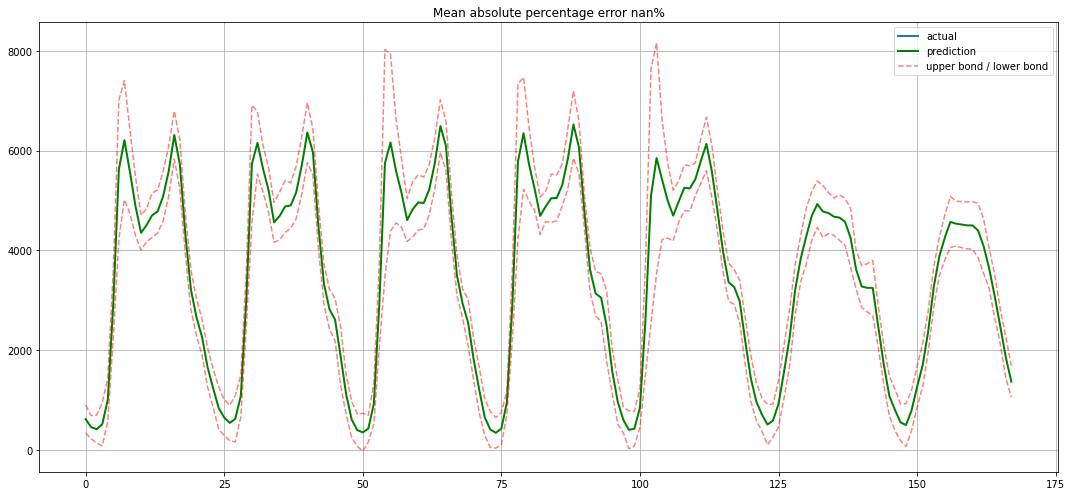

In [40]:
# создаем датафрейм для выполнения прогнозных расчётов
X_forecast, Y_forecast, feat_cols_forecast, forecast_start_X_forcast = prepare_train_data(data_new.x)
Y_forecast_df = pd.DataFrame(Y_forecast.values, index=Y_forecast.index, columns=['x'])
df_forecast_full = build_forecast_df(Y_forecast_df, feat_cols_forecast, forecast_start_X_forcast, forecast_horizon=168)

# считаем ошибки при обучении модели для внесения шума (стандартного отклонения ошибок) в модель
errors = get_train_forecast_errors(xgb_best_model, X_forecast, Y_forecast)

# выполнение прогноза с шумом на бутстрэп-выборках
df_xgb_forc_sample = sample_bootstrap_forecasts(xgb_best_model, df_forecast_full, n_samples=30, noise_std=errors.std())

# определяем стандартное отклонение ошибок (шум) по бутстрэп-выборкам
error_std = df_xgb_forc_sample.std(axis=1)

# выполняем прогнозный расчет
df_forecasted_full = recursive_predict(xgb_best_model, df_forecast_full)

# создаем пустой датасет, т.к. фактических значений у нас нет
empty_df = pd.DataFrame(None, index=df_forecasted_full.index, columns=['x'])

# строим график прогноза с доверительным интервалом
plotRecursivePredictionConfInterval(empty_df.x, df_forecasted_full.x, error_std)

Недельный прогноз выглядит реалистично - 5 рабочих дней с большей загрузкой метро + 2 выходных с меньшей загрузкой.